## Shot Scale analysis over time

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, spearmanr
from dotenv import load_dotenv


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# from util import get_keyframe_paths

In [49]:
load_dotenv()

CHAPTERS_DATA_TSV = Path(os.getenv("CHAPTERS_DATA_TSV")).resolve()
SHOT_SCALE_CLASSIFICATIONS_DIR = Path(os.getenv("SHOT_SCALE_CLASSIFICATIONS_DIR")).resolve()
long_shot = "Long Shot"
medium_shot = "Medium Shot"
close_shot = "Close-up"

In [50]:
def get_shots_ratio(row: pd.Series, shot_scale: str) -> float | None:
    filename = row["filestem"] + "_" + row["chapter"] + ".csv"
    path = SHOT_SCALE_CLASSIFICATIONS_DIR / filename
    if not path.is_file():
        return None
    try: 
        df = pd.read_csv(path)
        n = len(df)
        if n == 0:
            return None
        shots = len(df[df["prediction"] == shot_scale])
        return shots / n
    except Exception as e:
        print(e)
        return None

In [51]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Only data with timestamps
df = df[(df["start"].notna()) & (df["end"].notna())]
len(df)

2369

In [52]:
DF_COMBAT = df[(df["is_combat_scene"].notna()) & (df["is_combat_scene"])]
DF_WAR_REPORT = df[(df["is_war_report"].notna()) & (df["is_war_report"])]
DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]

In [53]:
df_description = "flagged as combat scenes"
df = DF_COMBAT

print(f"Data size: {len(df)}")

df["long_shots_ratio"] = df.apply(lambda row: get_shots_ratio(row, long_shot), axis=1)
df["medium_shots_ratio"] = df.apply(lambda row: get_shots_ratio(row, medium_shot), axis=1)
df["close_shots_ratio"] = df.apply(lambda row: get_shots_ratio(row, close_shot), axis=1)

Data size: 751


In [54]:
df["long_shots_ratio"].describe()

count    748.000000
mean       0.668247
std        0.172129
min        0.160714
25%        0.560000
50%        0.681818
75%        0.794232
max        1.000000
Name: long_shots_ratio, dtype: float64

In [60]:
df["medium_shots_ratio"].describe()

count    748.000000
mean       0.086452
std        0.099890
min        0.000000
25%        0.000000
50%        0.055556
75%        0.125000
max        0.631579
Name: medium_shots_ratio, dtype: float64

In [61]:
df["close_shots_ratio"].describe()

count    748.000000
mean       0.245301
std        0.159029
min        0.000000
25%        0.136364
50%        0.222222
75%        0.333333
max        0.833333
Name: close_shots_ratio, dtype: float64

In [55]:
df = df[df["long_shots_ratio"].notna()]

In [56]:
x = df['episode']
y = df['long_shots_ratio']

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)
mean = df["long_shots_ratio"].mean()
median = df["long_shots_ratio"].median()
std = df["long_shots_ratio"].std()
print(f"Median: {median:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")
print(f"Pearson:\tr = {pearson_r}\tp={pearson_p}")
print(f"Spearman:\tr = {spearman_r}\tp={spearman_p}")

Median: 0.68
Mean: 0.67
Standard deviation: 0.17
Pearson:	r = -0.24461879843446765	p=1.1824716636405002e-11
Spearman:	r = -0.22827331328218853	p=2.67865227909076e-10


In [57]:
df = df[df["long_shots_ratio"].notna()]

In [63]:
episode_stats = df.groupby(['episode', 'year'])['long_shots_ratio'].agg(
    mean_wide_shot_ratio='mean',
    median_wide_shot_ratio='median',
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
).reset_index()

/tmp/ipykernel_73319/2757118645.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(year_ticks.index.astype(int) - 1)


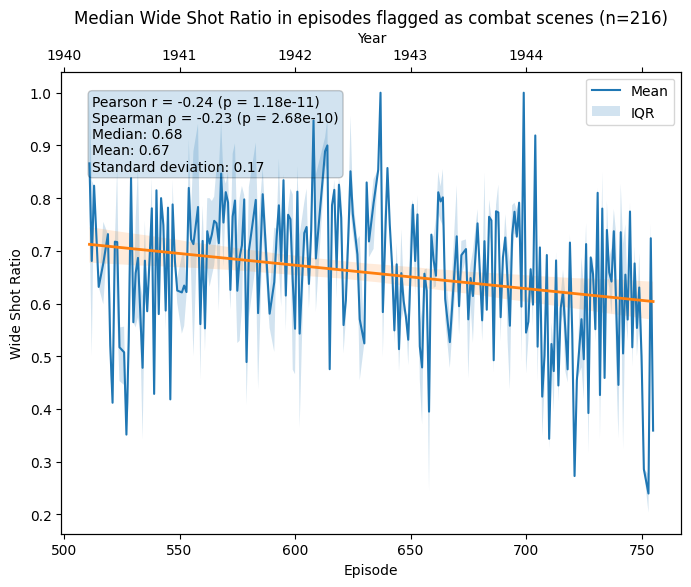

In [66]:
plt.figure(figsize=(8, 6))
text = (
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3g})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3g})\n"
    f"Median: {median:.2f}\n"
    f"Mean: {mean:.2f}\n"
    f"Standard deviation: {std:.2f}"
)
sns.lineplot(data=episode_stats, x="episode", y="mean_wide_shot_ratio", label="Mean")
plt.fill_between(
    episode_stats["episode"], episode_stats["q25"], episode_stats["q75"], alpha=0.2, label="IQR"
)
ax = sns.regplot(
    x=episode_stats["episode"],
    y=episode_stats["mean_wide_shot_ratio"],
    scatter=False,
    line_kws={"linewidth": 2},
)
plt.text(
    0.05,
    0.95,
    text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", alpha=0.2),
)

plt.xlabel("Episode")
plt.ylabel("Wide Shot Ratio")
plt.title(f"Median Wide Shot Ratio in episodes {df_description} (n={len(episode_stats)})")
ax.legend()

year_ticks = episode_stats.groupby("year")["episode"].min()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(year_ticks.index.astype(int) - 1)
ax2.set_xlabel("Year")
plt.show()